# Introduction

### Cats and Dogs

In [1]:
from fastai.vision.all import *

In [8]:
path = untar_data(URLs.PETS)/'images'
path

Path('/storage/data/oxford-iiit-pet/images')

In [9]:
def is_cat(x): return x[0].isupper()

In [10]:
dls = ImageDataLoaders.from_name_func(
        path, get_image_files(path), label_func=is_cat,
        valid_pct=0.2, seed=42, item_tfms=Resize(224)
        )

In [11]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)

In [12]:
learn.fine_tune(1)

epoch,train_loss,valid_loss,error_rate,time
0,0.177459,0.018380,0.006766,00:26


epoch,train_loss,valid_loss,error_rate,time
0,0.057604,0.022847,0.008796,00:30


# Downloading Images from DuckDuckGo

### Bear Identifier

`search_images_ddg()` function in this instance was not up-to-date.  
So, the latest version of fastbook was pulled from github.  
To be able to read the function from that location, we have to include that as the path for python

In [14]:
import sys
# insert at 1, 0 is the script path (or '' in REPL)
sys.path.insert(1, '/storage/fastbook')

Import this specific function from '`utils.py` file in the fastbook code

In [15]:
from utils import search_images_ddg

Seach 100 URLs for grizzle bear

In [17]:
urls = search_images_ddg('grizzly bear', max_n=100)

In [18]:
len(urls),urls[0]

(100, 'http://www.interestingfunfacts.com/files/2012/04/grizzly-bear.jpg')

Test if the urls are right by checking one of them

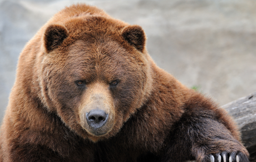

In [27]:
download_url(urls[0], 'images/bear.jpg')
im = Image.open('images/bear.jpg')
im.thumbnail((256,256))
im

Now find images for three kinds of bears and save images in folder

In [33]:
bear_types = 'grizzly','black','teddy'
path = Path('./images/bears')

In [34]:
path

Path('images/bears')

In [62]:
if not path.exists():
    path.mkdir()
    for o in bear_types:
        dest = (path/o)
        dest.mkdir(exist_ok=True)
        results = search_images_ddg(f'{o} bear', max_n=200)
        
        # Download images
        i=0
        for url in results:    
            if url[-4:] in ['.png','.jpg','.PNG','.JPG']:
                i+=1
                if i==100:
                    break

                file_`name = (dest/f'{o}_bear_{i}{url[-4:]}')
                try:
                    download_url(url, file_name)
                except:
                    continue

Check if the path now has images

In [63]:
fns = get_image_files(path)
fns

(#293) [Path('images/bears/grizzly/grizzly_bear_35.jpg'),Path('images/bears/grizzly/grizzly_bear_83.jpg'),Path('images/bears/grizzly/grizzly_bear_59.jpg'),Path('images/bears/grizzly/grizzly_bear_62.jpg'),Path('images/bears/grizzly/grizzly_bear_44.jpg'),Path('images/bears/grizzly/grizzly_bear_96.jpg'),Path('images/bears/grizzly/grizzly_bear_92.jpg'),Path('images/bears/grizzly/grizzly_bear_61.jpg'),Path('images/bears/grizzly/grizzly_bear_15.jpg'),Path('images/bears/grizzly/grizzly_bear_46.jpg')...]

Find and delete corrupt image files

In [64]:
failed = verify_images(fns)
failed

(#4) [Path('images/bears/grizzly/grizzly_bear_50.jpg'),Path('images/bears/teddy/teddy_bear_13.jpg'),Path('images/bears/teddy/teddy_bear_65.jpg'),Path('images/bears/black/black_bear_13.jpg')]

In [65]:
failed.map(Path.unlink);

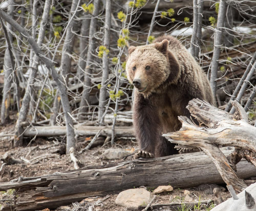

In [72]:
im = Image.open(fns[0])
im.thumbnail((256,256))
im

Tell fastai about the type of data using datablock

In [73]:
bears = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))

Tell fastai about the path to the data

In [74]:
dls = bears.dataloaders(path)
dls

Look at some of the images

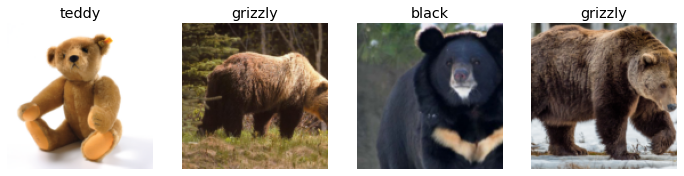

In [77]:
dls.train.show_batch(max_n=4, nrows=1)

The items transforms earlier mentioned resizes images by reshaping. Instead, we have following options:
- pad zeros to the image
- squish/stretch the image
- randomly crop different parts of the image and use those parts for training

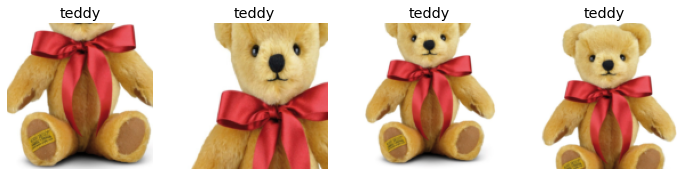

In [83]:
#bears.new(item_tfms=Resize(128, ResizeMethod.Pad, pad_mode='zeros'))
#bears.new(item_tfms=Resize(128, ResizeMethod.Squish))
bears.new(item_tfms=RandomResizedCrop(128, min_scale=0.3))
dls = bears.dataloaders(path)
#dls.train.show_batch(max_n=4, nrows=1)
dls.train.show_batch(max_n=4, nrows=1, unique=True)

We can also transform the image in multiple ways by rotating, changing contrast, distorting, etc

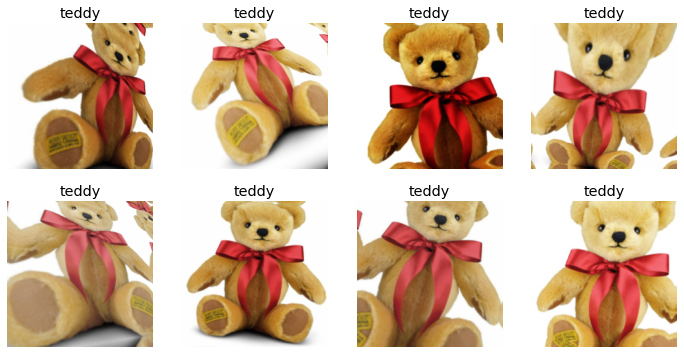

In [88]:
bears.new(item_tfms=RandomResizedCrop(224, min_scale=0.5), batch_tfms=aug_transforms(mult=2))
dls =bears.dataloaders(path)
dls.train.show_batch(max_n=8, nrows=2, unique=True)

### Train the model

Learner

In [91]:
learn = cnn_learner(dls, resnet18, metrics=error_rate)

In [92]:
learn.fine_tune(4)

epoch,train_loss,valid_loss,error_rate,time
0,1.791731,0.251694,0.105263,00:08


epoch,train_loss,valid_loss,error_rate,time
0,0.466575,0.173259,0.070175,00:07
1,0.360743,0.071637,0.035088,00:07
2,0.281055,0.057855,0.017544,00:08
3,0.240356,0.054937,0.017544,00:08


Create Confusion Matrix

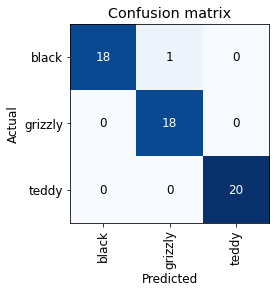

In [93]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

Let us see the examples with maximum loss

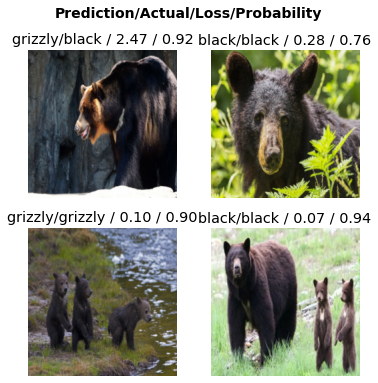

In [96]:
interp.plot_top_losses(4, nrows=2)

If you want to correct some labels, fastai can help

In [99]:
from utils import *
from fastai.vision.widgets import * 
cleaner = ImageClassifierCleaner(learn)
cleaner